## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [3]:
import string
import os
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from IPython.display import clear_output
from random import sample

In [4]:
# nltk.download('punkt')

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

### Data loading: "Евгений Онегин"


In [5]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
text = [re.sub(r"[^а-я]", " ", string.lower()) for string in text]

text = [re.sub(r"\s+", " ", string)[:-1] for string in text if string]

text = [string+'' for string in text if string != '']

In [8]:
text_for_token = ' '.join(text)

In [9]:
text = [string.split(' ') for string in text]

In [10]:
MAX_LENGTH = max(map(len, text))

In [11]:
text

[['', 'мой', 'дядя', 'самых', 'честных', 'правил'],
 ['когда', 'не', 'в', 'шутку', 'занемог'],
 ['он', 'уважать', 'себя', 'заставил'],
 ['и', 'лучше', 'выдумать', 'не', 'мог'],
 ['его', 'пример', 'другим', 'наука'],
 ['но', 'боже', 'мой', 'какая', 'скука'],
 ['с', 'больным', 'сидеть', 'и', 'день', 'и', 'ночь'],
 ['не', 'отходя', 'ни', 'шагу', 'прочь'],
 ['какое', 'низкое', 'коварство'],
 ['полуживого', 'забавлять'],
 ['ему', 'подушки', 'поправлять'],
 ['печально', 'подносить', 'лекарство'],
 ['вздыхать', 'и', 'думать', 'про', 'себя'],
 ['когда', 'же', 'черт', 'возьмет', 'тебя'],
 ['так', 'думал', 'молодой', 'повеса'],
 ['летя', 'в', 'пыли', 'на', 'почтовых'],
 ['всевышней', 'волею', 'зевеса'],
 ['наследник', 'всех', 'своих', 'родных'],
 ['друзья', 'людмилы', 'и', 'руслана'],
 ['с', 'героем', 'моего', 'романа'],
 ['без', 'предисловий', 'сей', 'же', 'час'],
 ['позвольте', 'познакомить', 'вас'],
 ['онегин', 'добрый', 'мой', 'приятель'],
 ['родился', 'на', 'брегах', 'невы'],
 ['где', 'може

Put all the characters, that you've seen in the text, into variable `tokens`.

In [149]:
tokens = word_tokenize(text_for_token)

In [150]:
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [151]:
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

idx_to_token = {idx: token for idx, token in enumerate(tokens)}

In [152]:
token_to_idx['\n'] = max(token_to_idx.values()) + 1
idx_to_token[max(idx_to_token.keys()) + 1] = '\n'


token_to_idx[''] = max(token_to_idx.values()) + 1
idx_to_token[max(idx_to_token.keys()) + 1] = ''

In [153]:
def to_matrix(names, max_len=None, pad=token_to_idx[''], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [154]:
print(text[:5])
batch_ix = to_matrix(text[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(batch_ix)

[['', 'мой', 'дядя', 'самых', 'честных', 'правил'], ['когда', 'не', 'в', 'шутку', 'занемог'], ['он', 'уважать', 'себя', 'заставил'], ['и', 'лучше', 'выдумать', 'не', 'мог'], ['его', 'пример', 'другим', 'наука']]
tensor([[22447, 22320,  2656,  4656,     3,  4008],
        [21994, 22431, 22383,     8,     9, 22447],
        [22194,  9152, 17170,    13, 22447, 22447],
        [22435, 21838,    16, 22431, 22305, 22447],
        [21774,    20,  8475,   450, 22447, 22447]])


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [155]:
num_tokens = max(idx_to_token.keys()) + 1

class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=MAX_LENGTH, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_0):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h_n = self.rnn(self.emb(x), h_0)        
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return h_n, next_logp
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.num_units, requires_grad=True)

In [156]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()

history = []

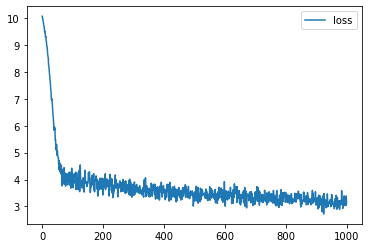

In [157]:
for i in range(1000):
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    h_0 = model.initial_state(batch_size = 32)
    
    _, logp_seq = model(batch_ix, h_0)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [220]:
def generate_sample(model, seed_phrase=['мой'], max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, out = model(x_sequence[:, :,i], hid_state)
    
    #start generating
    for i in range(max_length - len(seed_phrase)):
        if x_sequence[:, :,-1] == torch.tensor([[[22446]]]):
            hid_state, out = model(x_sequence[:, :,-2], hid_state)
        else:
            hid_state, out = model(x_sequence[:, :,-1], hid_state)
        
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][0]
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        if next_ix == torch.tensor([[[22447]]]):
            next_ix = torch.tensor([[[22446]]])
            hid_state = model.initial_state(batch_size=1)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    x_sequence = torch.flatten(x_sequence)
    
    return ' '.join([idx_to_token[ix] for ix in x_sequence.data.numpy()])

In [231]:
for _ in range(1):
    print(generate_sample(model, max_length=200, seed_phrase=['мой','дядя']))

мой дядя оленька 
 ног он срок твоя 
 небрежно моих дело 
 б завеса мой 
 грустит и едет содрогнулась 
 и беседовать далеком лель пестрых 
 зерно любви друга себя 
 минувших и оковы 
 нею нам 
 терпсихоре наедине 
 вздох ней 
 мечтанье нас 
 вас досуга наудачу 
 сладостной не 
 затеи и ж бежал 
 ее смертью болван сейчас 
 духовными пени 
 шепчут милы и на садится 
 находит колкий драла 
 влюблена шум богу 
 другие мое с 
 была старине дом вам слагает мятежной 
 спешит для того света 
 девы онегиным кровь надев 
 тяжкий бестолкова старожил ваши 
 полей он тот евгений 
 стих гости 
 возках дев 
 совьет могу хвостиком одно через 
 них и одной 
 не видит ваша летит 
 своенравие всех вас туз 
 злою негодованье 
 б строфах и 
 приятна милая ей крик 
 дяди и затем привлекут 
 женщин 
 жердочки уж ленский из порой сносней 
 жизни нас онегину попал 
 назад простоте 
 стала гусей 
 милые бала 
 приходит на грудь 
 дорисован 
 втайне старался перестань дней 
 ничем с моей 
 черные завтра водой 
 

In [120]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [224]:
num_tokens = max(idx_to_token.keys()) + 1

class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=MAX_LENGTH, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_0, c_0):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h = self.lstm(self.emb(x), (h_0,c_0))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return h[0], h[1], next_logp
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.num_units, requires_grad=True)

In [225]:
model2 = CharLSTMLoop()
opt = torch.optim.Adam(model2.parameters())
criterion = nn.NLLLoss()

history = []

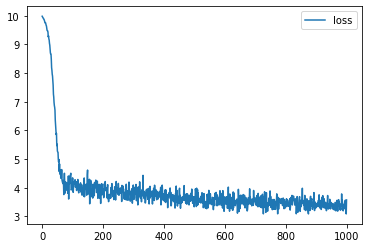

In [226]:
for i in range(1000):
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    h_0 = model2.initial_state(batch_size = 32)
    hn, cn, logp_seq = model2(batch_ix, h_0, h_0)
    
    predictions_logp = logp_seq[:, :-1]    
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [232]:
def generate_sample_lstm(model, seed_phrase=['мой'], max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = model.initial_state(batch_size=1)
    cn = model.initial_state(batch_size=1)
    
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, cn, out = model(x_sequence[:, :,i], hid_state, cn)
    
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        if x_sequence[:, :,-1] == torch.tensor([[[22446]]]):
            hid_state, cn, out = model(x_sequence[:, :,-2], hid_state, cn)
        else:
            hid_state, cn, out = model(x_sequence[:, :,-1], hid_state, cn)
        
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        if next_ix == torch.tensor([[[22447]]]):
            next_ix = torch.tensor([[[22446]]])
            hid_state = model.initial_state(batch_size=1)  
            cn = model.initial_state(batch_size=1)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
        
    x_sequence = torch.flatten(x_sequence)
    
        
    return ' '.join([idx_to_token[ix] for ix in x_sequence.data.numpy()])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [244]:
for _ in range(1):
    print(generate_sample_lstm(model2, seed_phrase=['мой','дядя'], max_length = 50, temperature = 1.2))

мой дядя тошно воображенье 
 журнал света льется брани 
 богу кустах проклиная 
 прежнюю смело сне 
 онегин ты голос добро тому 
 взаймы страшные ищу 
 дружной по вакханочка стороны вампир 
 татьяна эти половиной пору моде 
 не 
 постель он он хор 
 своих толку долинах


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [246]:
import pickle

In [247]:
with open('model_RNN.pkl', 'wb') as handle:
    pickle.dump(model, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [248]:
with open('model_LSTM.pkl', 'wb') as handle:
    pickle.dump(model2, handle, protocol = pickle.HIGHEST_PROTOCOL)

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)